# Sparse segmentation - MAP & MRF

**2019-05-06**

Used to generate the MAP and MRF figures and results

In [1]:
from __future__ import division # integer division now yields floating-point numbers

import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

from glob import glob           # file manipulation
import numpy as np
import pandas as pd
from skimage.io import imread, imsave   # image processing
from scipy.optimize import curve_fit, minimize, basinhopping, fmin_l_bfgs_b, differential_evolution
from scipy.stats import *      # stats utils
from scipy.signal import correlate, correlate2d, fftconvolve

import cv2
import re

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

%load_ext line_profiler

In [2]:
from sonar import Sonar
import utils

didson = Sonar();
didson.load_config('../data/DIDSON/didson.json')
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise
print 'RX gain:', didson.rx_gain,'dB'

Pings are 96 beams by 512 bins
Field of view: 0.502862655531
Range: 0.75  -  9.75 m.
Noise: 0.002
RX gain: 20.0 dB


In [6]:
root = '/home/pvt/workspace/projects/project-hauv/post/2018-03-14.00_backup/pings/'
images = sorted(glob(root+'*raw_polar.png')) # window set to 2.25m to 11.25m
configs = sorted(glob(root+'*.json'))

print len(images),'image files,',len(configs),'config files'
N = len(images) 

output_path =  'output/cmm-sparse-mrf/2018-03-14.00/'
idx = 6000
M = 3000

57392 image files, 0 config files


In [5]:
root = '/home/pvt/workspace/projects/project-hauv/post/2017-03-16.00/pings/'
images = sorted(glob(root+'*raw_polar.png')) # window set to 2.25m to 11.25m
configs = sorted(glob(root+'*.json'))

print len(images),'image files,',len(configs),'config files'
N = len(images) 

output_path =  'output/cmm-sparse-mrf/2017-03-16.00/'
idx = 4000
M = 500

0 image files, 0 config files


In [7]:
def get_template(dr=9.0/512, l=-10.0):
    """
    Get template function for the pseudo match filter
    """
    r = np.arange(0,1,dr)
    pulse = np.exp(l*r)
    return pulse

def correlate(ping, pulse):
    """
    Compute radial correlation in image (matched filter)
    """
    pulse.shape = (len(pulse), 1)
    # q = correlate(ping, pulse, mode='full')
    # scipy's fftconvolve is much faster than correlate
    q_ping = fftconvolve(ping, pulse[::-1], mode='full') # 2ms
    q_ping = np.copy(q_ping[(len(pulse)-1):, :])
    assert ping.shape==q_ping.shape
    return q_ping

def reconstruct(ping, ranges):
    """
    reconstruct the image from the range measurements
    """
    ping2 = np.zeros_like(ping)
    for i in range(0, len(ranges)):
        if ranges[i]>0:
            ping2[ranges[i],i] = 1.0
    return ping2

def segment_smap(ping, pulse, threshold=1.0):
    """
    Scan segmentation via per-beam matched filter.
    """
    q_ping = correlate(ping, pulse)
    q_ping[q_ping < threshold] = 0
    idx = np.argmax(q_ping, axis=0)
    return idx

def smrf_obj(idx, q_ping, l=-1, bw=1.0):
    """
    Objective function for sparse mrf computation

    r: range estimate
    q_ping: correlation image
    l: exponential factor
    bw: binary factor weight

    TODO: handle non-contiguous vectors, or assume that is handled outside
    """
    # 
    if np.any(idx>511):
        print idx
    u=0
    for i in range(0, len(idx)):
        u +=q_ping[idx[i],i] # unary cost: correlation at the given range
    b =  np.sum(np.exp(l*np.abs(np.diff(idx))))# binary cost:
    return u + bw*b


In [6]:
def compute_transition_energy(ping, r, l=-0.10):
    """
    Compute transition energy matrix for the current label assignment.
    
    TODO: vectorize this as much as possible - the double-nested for-loops are expensive
    """
    bins, beams = ping.shape 
    T = np.zeros((bins, beams))
    j = np.arange(bins)
#     ones = np.ones(bins)
    for i in range(beams):
        if i > 0 and i < beams-1: 
            if (r[i]>0) or (r[i-1]>0 and r[i+1]>0):
                T[:,i] = 0

                if r[i-1] > 0:
                    T[:,i] = np.exp(l*np.abs(r[i-1]-j))
                    
                if r[i+1] > 0:
                    T[:,i] += np.exp(l*np.abs(r[i+1]-j))
        elif i==0:
            if r[0]>0:
                if r[1] > 0:
                    T[:,i] = np.exp(l*np.abs(r[1]-j))
                else:
                    T[:,0] = 0
#                 for j in range(bins):
#                     T[j,0] = (np.exp(l*abs(j-r[1])), 0)[r[1]==0]
        else:
            if r[i]>0:
                if r[i-1] > 0:
                    T[:,i] = np.exp(l*np.abs(r[i-1]-j))
                else:
                    T[:,i] = 0.0                                                  
    return T

def segment_smap(ping, pulse, threshold=.40)
   """
   sparse MAP segmentation
   """
        
    Q = correlate(ping, pulse)
    Q[Q < threshold] = 0

    x0 = np.argmax(Q, axis=0)
    return x0
    

def segment_smrf(ping, pulse, threshold=.40, iterations=10):
    """
    energy maximization
    """
    
    Q = correlate(ping, pulse)
    Q[Q < threshold] = 0

    x0 = np.argmax(Q, axis=0) # local MAP solution as initialization
    x = np.copy(x0)
    
    for i in range(iterations):
        T = compute_transition_energy(ping, x, (-0.10*(i+1))/iterations)
        E = Q + T
        x = np.argmax(E, axis=0)

    return x0, x, E
    
    

In [7]:
np.rad2deg(didson.azimuth(48))

-0.74095229124938766

Saving results to output/cmm-sparse-mrf/2017-03-16.00/
processing 1489682076147444
processing 1489682076243050
processing 1489682077148837
processing 1489682077253429
processing 1489682077353093
processing 1489682077456911
processing 1489682077646053
processing 1489682077743236
processing 1489682077850255
processing 1489682077951290
processing 1489682078054773
processing 1489682078147018
processing 1489682078243458
processing 1489682078343769
processing 1489682078540577
processing 1489682078640293
processing 1489682078740471
processing 1489682078840911
processing 1489682078945979
processing 1489682079043684
processing 1489682079142105
processing 1489682079343576
processing 1489682080143498
processing 1489682080241987
processing 1489682081143550
processing 1489682081241648
processing 1489682081341970
processing 1489682081444063
processing 1489682081642943
processing 1489682081741187
processing 1489682081841060
processing 1489682081942551
processing 1489682082047787
processing 1489682082

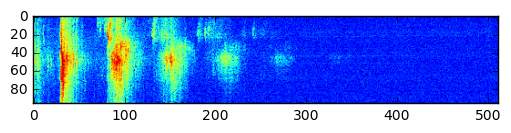

In [9]:
# %prun

levels=2**8
bg = 1.0

## initialize variables
bins = np.linspace(0, 1.0, levels+1)
k = np.linspace(0, 1.0, levels)

print 'Saving results to',output_path

R_map = np.zeros((96, M))
R_mrf = np.zeros((96, M))
fns = re.compile(r"[0-9]{16}")

pulse = get_template()

for i in range(M):
    filename = fns.findall(images[idx+i])[0]         # < 1us
    ping_raw = imread(images[idx+i], as_grey = True).astype(np.float64) # 1 ms
    ping_raw /= (levels-1.0)
    didson.load_config(configs[idx+i])               # < 1ms
    plt.imshow(ping_raw.transpose())
    
    print('processing '+filename)
    
    # 1. Pre-processing
    ping_raw_cart = didson.to_cart(ping_raw, bg) # 6 ms
    cv2.imwrite(output_path + filename+'_raw_cart.png',(255*ping_raw_cart).astype(np.uint8)) # 8 ms
    ping = didson.preprocess(ping_raw, True)     # 3-5 ms
    ping_cart = didson.to_cart(ping, bg)        # 4-6 ms
    cv2.imwrite(output_path + filename+'_pre_cart.png',(255*ping_cart).astype(np.uint8)) # 8 ms per loop

    # 2. Sparse segmentation
    r0, r1, e = segment_smrf(ping, pulse) # MAP, MRF, energy # this takes about a second
    
    # update range images
    R_map[:,i] = r0 
    R_mrf[:,i] = r1 
    
    # map
    ping_map = reconstruct(ping, r0)
    ping_map_cart = didson.to_cart(ping_map, bg) 
    cv2.imwrite(output_path + filename+'_sparse_map_cart.png',(255*ping_map_cart).astype(np.uint8)) # 8 ms per loop    
    
    # mrf
    ping_mrf = reconstruct(ping, r1)    
    ping_mrf_cart = didson.to_cart(ping_mrf, bg) 
    cv2.imwrite(output_path + filename+'_sparse_mrf_cart.png',(255*ping_mrf_cart).astype(np.uint8)) # 8 ms per loop


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
ri_map = np.copy(R_map)
ri_map[ri_map<=0]=np.nan
ri_map*=9.0/512
ri_map+=2.25 

ri_mrf = np.copy(R_mrf)
ri_mrf[ri_mrf<=0]=np.nan
ri_mrf*=9.0/512
ri_mrf+=2.25 

plt.figure(figsize=(12,3))
plt.subplot(2,1,1)
plt.imshow(ri_map)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(ri_mrf)
plt.axis('off')

cv2.imwrite(output_path+'ri_map.png', ri_map)
np.savetxt(output_path+'ri_map.csv', ri_map, delimiter=',', newline='\n')
plt.imsave(output_path+'ri_map_plot.png',ri_map,vmin=0,vmax=12)

cv2.imwrite(output_path+'ri_mrf.png', ri_mrf)
np.savetxt(output_path+'ri_mrf.csv', ri_mrf, delimiter=',', newline='\n')
plt.imsave(output_path+'ri_mrf_plot.png',ri_mrf,vmin=0,vmax=12)

